In [1]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2025-09-25 18:33:47.822929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758825228.059245      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758825228.126002      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


İlk olarak proje için kullanacağımız pirinç görüntülerini dosya sisteminden okuyoruz. Her bir alt klasör bir pirinç türünü temsil ediyor. Ben de bu klasörlerin içindeki tüm resim dosyalarının yolunu (image) ve hangi sınıfa ait olduklarını (label) listelere kaydettim. Son aşamada bu bilgileri bir pandas DataFrame kullanarak daha düzenli ve kolay işlenebilir bir tabloya dönüştürdüm.

In [2]:
data_path='/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

images=[]
labels=[]

for subfolder in os.listdir(data_path):
    subfolder_path=os.path.join(data_path,subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path=os.path.join(subfolder_path,image_filename)
        images.append(image_path)
        labels.append(subfolder)

df=pd.DataFrame({'image':images,'label':labels})

Bu satırda oluşturduğum DataFrame’in (df) içeriğine göz atmak için .head() fonksiyonunu kullandım. Bu fonksiyon, varsayılan olarak tablonun ilk 5 satırını gösteriyor. Böylece resim yollarının (image sütunu) doğru şekilde kaydedilip kaydedilmediğini ve etiketlerin (label sütunu) doğru eşleşip eşleşmediğini kontrol etmiş oluyorum.

In [3]:
df.head()

,image,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


Bu kısımda elimizdeki veri setini eğitim ve test olmak üzere ikiye ayırdım. %80’i eğitim verisi, %20’si test verisi olacak şekilde böldüm. Daha düzenli kullanabilmek için hem eğitim hem de test verileri için ayrı DataFrame’ler oluşturdum. Ardından etiketler (label) metin (örneğin “Basmati”, “Jasmine”) olarak duruyordu. Derin öğrenme modelleri sayısal verilerle çalıştığı için bu etiketleri LabelEncoder kullanarak sayılara dönüştürdüm. Böylece modelim artık pirinç türlerini 0, 1, 2, 3, 4 gibi sayılarla ifade edebilecek.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df['image'],df['label'], test_size=0.2, random_state=42)

df_train=pd.DataFrame({'image':x_train, 'label': y_train})

df_test=pd.DataFrame({'image':x_test, 'label':y_test})

encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.transform(y_test)

Burada eğitim verilerini hazırlıyorum. Öncelikle ImageDataGenerator kullanarak veri artırma (Data augmentation) işlemleri tanımladım. Bunun amacı, modelin sadece aynı görüntülerle değil, farklı açılardan döndürülmüş, kaydırılmış veya yakınlaştırılmış halleriyle de eğitilmesi. Böylece modele daha genel, sağlam ve overfitting yapmayan bir öğrenme sağlanacak.

Daha sonra flow_from_dataframe fonksiyonuyla, eğitim verilerimi batch’ler halinde (32’lik gruplar) modele besleyecek bir jeneratör oluşturdum. Ayrıca tüm resimleri 100x100 piksele yeniden boyutlandırdım ve sınıfları categorical (çok sınıf) olarak ayarladım.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1.0/255,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 60000 validated image filenames belonging to 5 classes.


Burada test verilerini modele hazırlıyorum. Eğitim verisinde yaptığım gibi flow_from_dataframe ile görselleri jeneratör haline getiriyorum. Fakat burada değinmem gereken önemli bir nokta var. Eğitim verisinde rotation, zoom, shift gibi data augmentation işlemleri uyguladım. Bunun amacı modelin daha genelleştirilebilir olmasıydı ama test verisinde ise augmentation kullanılmaz. Çünkü test setinin amacı, modeli gerçek veriler üzerinde tarafsız şekilde değerlendirmektir. Eğer test verilerini de dönüştürürsek, modelin gerçek başarısını ölçemeyiz.

Bu yüzden test setinde aslında sadece rescale işlemi aktif kalır. Ayrıca shuffle=False ayarıyla, test verilerinin sırası karışmaz. Böylece modelin yaptığı tahminleri doğru etiketlerle birebir karşılaştırabilirim.

In [6]:
test_generator=train_datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 15000 validated image filenames belonging to 5 classes.


Bu kısımda da eğitim sırasında kullanılacak olan validation setini hazırlıyorum.flow_from_directory fonksiyonunu kullanarak, klasörden doğrudan doğrulama verilerini üretiyorum. Resimleri yine 100x100 piksele küçültüyorum. batch_size=512 seçerek her seferde 512 resim işlenmesini istedim. (Bu değeri büyük tuttuğum için eğitim sırasında daha hızlı ilerleme sağlanacak).

subset='validation' olarak ayarladığımda, ImageDataGenerator’un ayırdığı verinin doğrulama kısmı seçilmiş oluyor.

Burada da önemli bir nokta var. Validation verileri de tıpkı test seti gibi eğitimdeki gibi dönüşümlere (rotation, zoom, flip vb.) uğramaz. Yalnızca rescale işlemi uygulanır. Çünkü validation setinin amacı, eğitim sırasında modelin aşırı ezberleyip ezberlemediğini takip etmektir.

In [7]:
validation_generator = train_datagen.flow_from_directory(data_path,
 target_size=(IMG_WIDTH,IMG_HEIGHT),
 batch_size=512,
 class_mode='categorical',
 shuffle=True,
 subset='validation')

Found 0 images belonging to 5 classes.


Burada modelin sınıfları nasıl numaralandırdığını görmek istedim.

train_generator.class_indices bize her sınıfın adını ve ona karşılık gelen sayıyı döndürür. Ben burada tersine çevirerek (0: "Basmati", 1: "Jasmine", ...) şeklinde bir yapı oluşturdum. Döngü ile bu eşleşmeleri ekrana yazdırarak, modelin hangi numarayı hangi pirinç türü için kullandığını kontrol ettim.

Burası önemli, çünkü eğitim ve tahmin sonrasında sayısal etiketleri gerçek pirinç isimleriyle ilişkilendirmemizi sağlıyor.

In [8]:
labels = {value: key for key, value in train_generator.class_indices.items()}
for key, value in labels.items():
  print(f"{key} : {value}")

0 : Arborio
1 : Basmati
2 : Ipsala
3 : Jasmine
4 : Karacadag


Sonraki aşama olarak veri setindeki görselleri görselleştirmek istedim.Her pirinç türünden (sınıftan) 5 örnek seçtim ve onları yan yana gösterdim. Böylece hangi resmin hangi pirinç türüne ait olduğunu kolayca görebiliriz. Burada amacım veri setini görselleştirerek hangi türlerden kaç tane resim olduğunu ve resimlerin çeşitliliğini görmek, böylece eğitim öncesi veri hakkında fikir sahibi olabiliriz.

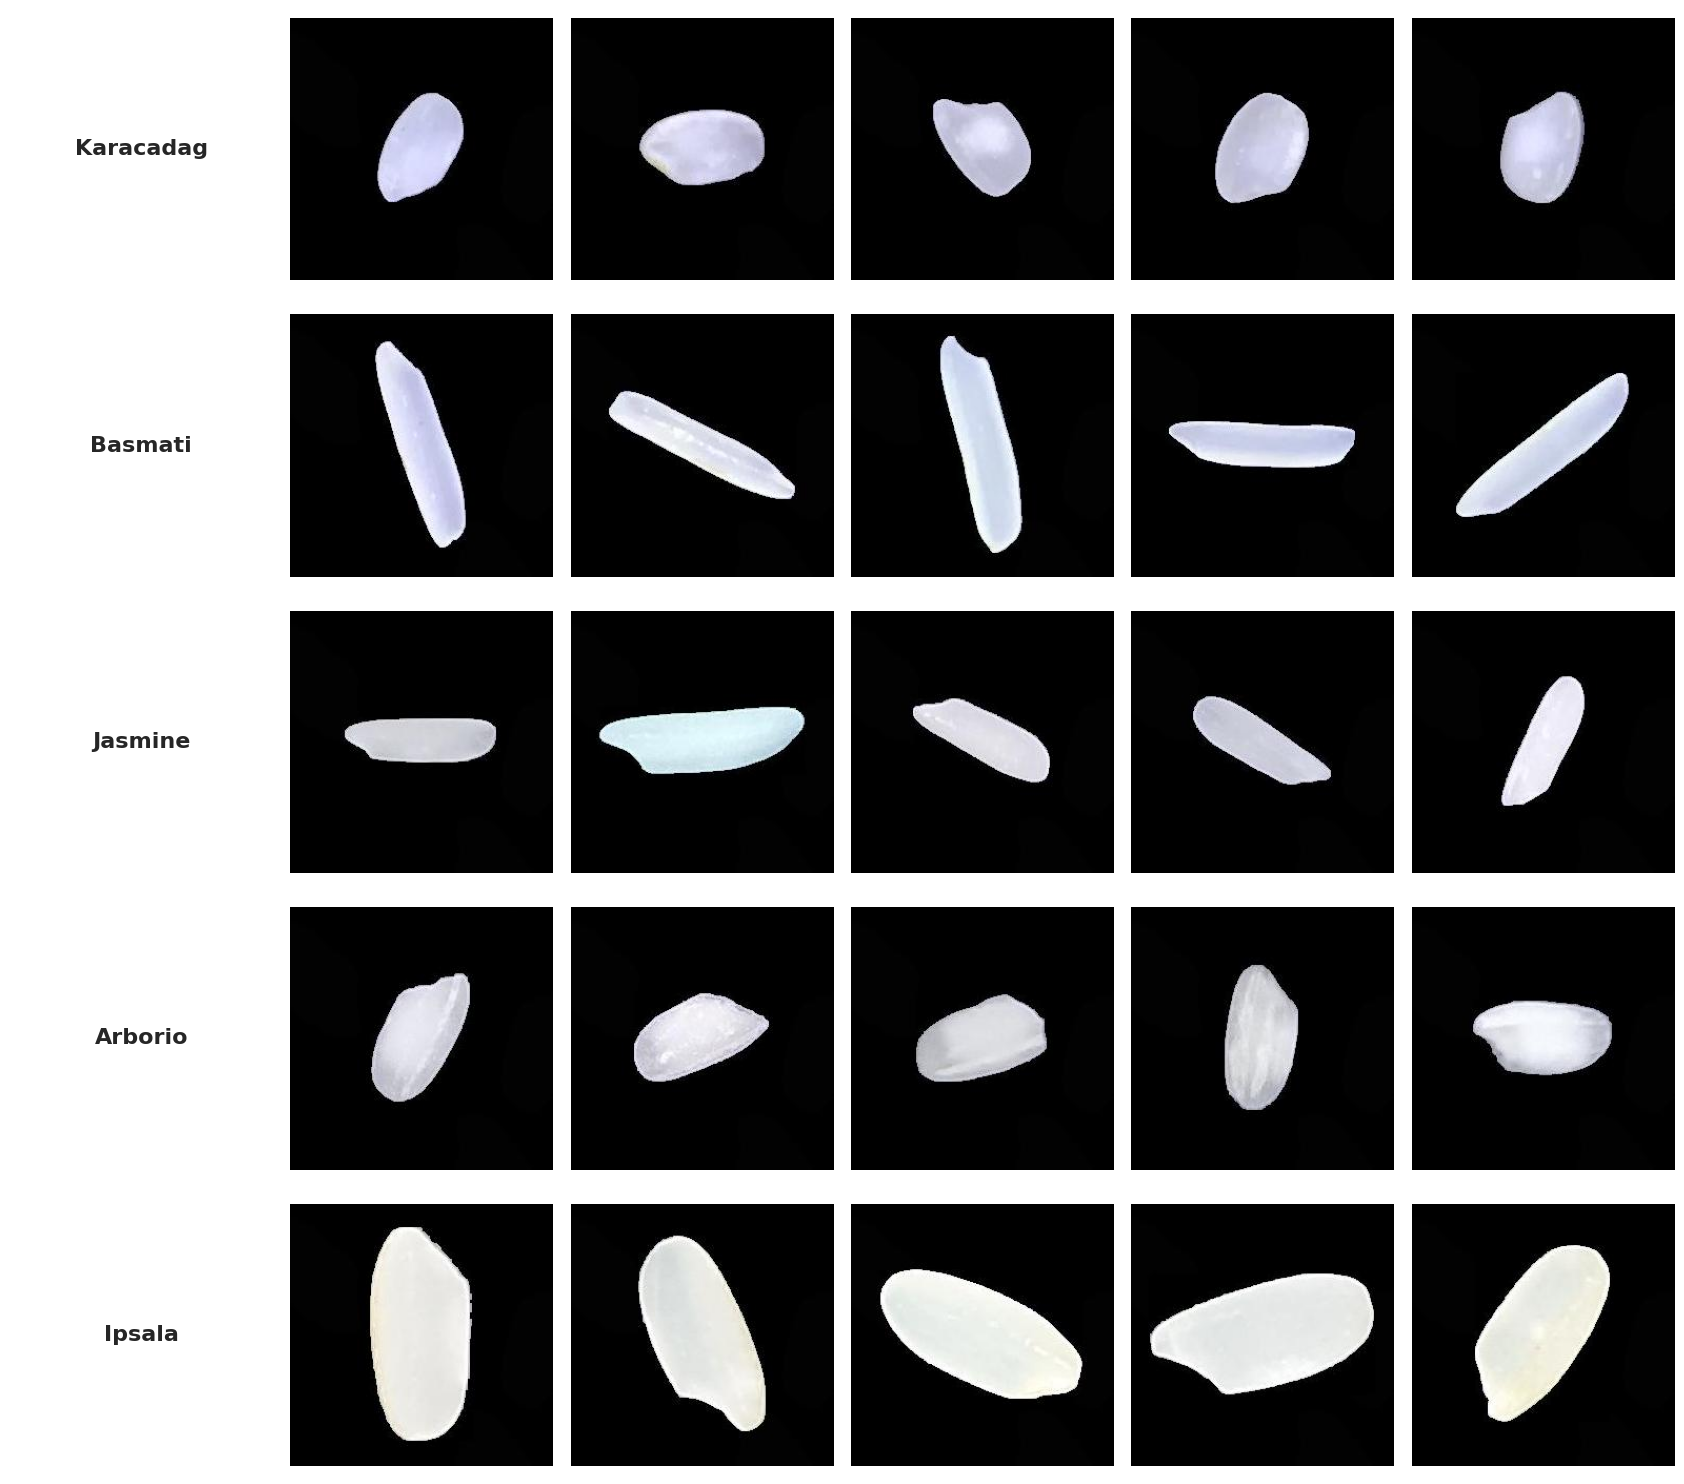

In [ ]:
import matplotlib.image as mpimg

images_per_class = 5
unique_labels = df['label'].unique()
n_classes = len(unique_labels)


fig, axes = plt.subplots(n_classes, images_per_class + 1, figsize=(images_per_class * 3 + 2, n_classes * 3))

for row, category in enumerate(unique_labels):
    
    filepaths = df[df['label'] == category]['image'].values[:images_per_class]
    
    
    axes[row, 0].text(0.5, 0.5, category, fontsize=16, fontweight='bold', ha='center', va='center')
    axes[row, 0].axis('off')
    
  
    for col, filepath in enumerate(filepaths):
        axes[row, col + 1].imshow(mpimg.imread(filepath))
        axes[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

Bu blokta kendi CNN modelimi oluşturdum. Model 100x100 boyutunda ve renkli resimleri alıyor. İlk olarak 32 filtreli bir Conv2D katmanı ile resimlerden temel özellikleri öğrenmesini sağlayıp, sonra MaxPooling2D ile görselleri küçültüp en önemli özellikleri korumasını sağladım. Ardından 64 filtreli ikinci bir Conv2D ve bir MaxPooling2D katmanı ile daha karmaşık özellikleri yakalamasını istedim. Flatten katmanı ile tüm bu özellikleri tek boyuta indirdik ki Dense katmanında kullanabilelim. Dense katmanıyla bu özellikleri işledim ve en sonunda 5 pirinç türü için softmax çıkışı aldım. Yani modeli, elimize bir pirinç resmi geldiğinde hangi türe ait olduğunu tahmin edebilecek şekilde tasarladım.

In [10]:
input_shape=(100,100,3)

model=Sequential(
    [Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),                     
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')   
    ]
)

I0000 00:00:1758826040.846019      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Bu satırda modeli compile ediyorum. Modelin nasıl öğreneceğini ve başarısını nasıl ölçeceğini ayarladım. loss='categorical_crossentropy': Çünkü elimizde 5 farklı pirinç türü var ve çok sınıflı bir sınıflandırma yapıyoruz. Bu yüzden modelin hatasını ölçmek için categorical crossentropy kullandım.

optimizer='adam': Modelin ağırlıklarını güncellemek için Adam algoritmasını seçtim. Adam, daha hızlı ve verimli bir öğrenme yapıyor.

metrics=['accuracy']: Eğitim ve doğrulama sırasında modelin başarısını doğruluk (accuracy) ile takip edeceğiz.

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary() ile oluşturduğum CNN modelinin yapısını bakabiliriz. Hangi katmanların olduğu, her katmanın boyutunu ve çıktısını, öğrenilecek toplam parametre sayısını görebiliriz.

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353,733 (16.61 MB)

 Trainable params: 4,353,733 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

Burada modeli eğitirken en iyi performans gösterdiği halini kaydetmek için bir kontrol noktası (checkpoint) oluşturdum. ModelCheckpoint ile validation accuracy’yi takip ediyorum ve save_best_only=True sayesinde sadece en yüksek doğruluk elde edildiğinde model kaydediliyor. Modelin kaydedileceği dosya adını my_best_Model_v2.keras olarak belirledim ve mode='max' ile doğruluk değerinin maksimum olması durumunda kaydedileceğini söylüyorum. verbose=1 sayesinde kaydetme işlemleri ekranda gösteriyorum. Böylece eğitim sırasında modelin en iyi performans gösterdiği halini saklayabilir ve daha sonra tekrar kullanabilirim.

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

new_filepath="my_Best_Model_v2.keras"

checkpoint=ModelCheckpoint(
    filepath=new_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'

)

Şimdi oluşturduğum CNN modelini eğitmeye başlıyoruz. train_generator ile eğitim verilerini modele verdim ve model 5 epoch boyunca (yani tüm eğitim verilerini 5 kez) öğrenecek. batch_size=4 ile her seferinde 4 görsel işlenmesini istedim. Eğitim sırasında modelin performansını test_generator ile kontrol ediyoruz. Böylece model sadece eğitim verisini ezberlemiyor, aynı zamanda yeni verilere karşı ne kadar iyi genelleme yapabildiğini görebiliyoruz. Ayrıca, daha önce oluşturduğum checkpoint callback’i sayesinde, eğitim süresince modelin en yüksek doğruluk gösterdiği hali otomatik olarak kaydediliyor. Böylece hem modeli eğitmiş oluyorum hem de overfitting durumunu en iyi doğruluk seviyesinde önlemiş oluyorum

In [17]:
history=model.fit(
    train_generator,
    epochs=5,
    batch_size=4,
    validation_data=test_generator,
    callbacks=[checkpoint]
)

Epoch 1/5


I0000 00:00:1758826256.332616     130 service.cc:148] XLA service 0x7e852800aea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758826256.335666     130 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758826256.674168     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 2:35:18 5s/step - accuracy: 0.1875 - loss: 1.6170

I0000 00:00:1758826258.929054     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7472 - loss: 0.6033
Epoch 1: val_accuracy improved from -inf to 0.93060, saving model to my_Best_Model_v2.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 736s 390ms/step - accuracy: 0.7473 - loss: 0.6032 - val_accuracy: 0.9306 - val_loss: 0.1836
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.9483 - loss: 0.1426
Epoch 2: val_accuracy improved from 0.93060 to 0.97927, saving model to my_Best_Model_v2.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2238s 1s/step - accuracy: 0.9483 - loss: 0.1426 - val_accuracy: 0.9793 - val_loss: 0.0646
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9683 - loss: 0.0898
Epoch 3: val_accuracy did not improve from 0.97927
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 297s 159ms/step - accuracy: 0.9683 - loss: 0.0898 - val_accuracy: 0.9681 - val_loss: 0.0885
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9739 - loss: 0.0747
Epoch 4: val_accuracy improved from 0.97927 to 0.

Bu kod bloğunda, modelin eğitim sürecindeki başarısını görselleştiriyorum. İlk olarak eğitim ve doğrulama (validation) doğruluk değerlerini (accuracy ve val_accuracy) alıp, epoch’lara karşı çizdirdim. Böylece modelin her epoch sonunda eğitim ve test verisinde ne kadar iyi öğrendiğini görebiliriz. Eğitimin başında eğitim doğruluğu ve test doğruluğu birbirine yakınsa model iyi genelleme yapıyor demektir, ancak eğitim doğruluğu çok yükselip test doğruluğu geride kalıyorsa bu overfitting (modelin eğitim verisine fazla uyum sağlaması) işareti olabilir.

Aynı şekilde, eğitim ve doğrulama kayıp değerlerini (loss ve val_loss) alıp, bunları da çizdirdim. Kayıp grafikleri, modelin hatalarının zaman içinde nasıl azaldığını gösteriyor. Eğer eğitim kaybı çok düşerken doğrulama kaybı sabit kalır veya artarsa, bu da overfitting’in bir göstergesidir.

Bu görselleştirmeler sayesinde hem modelin öğrenme sürecini takip edebilir hem de overfitting veya underfitting gibi problemleri kolayca fark edebiliriz.

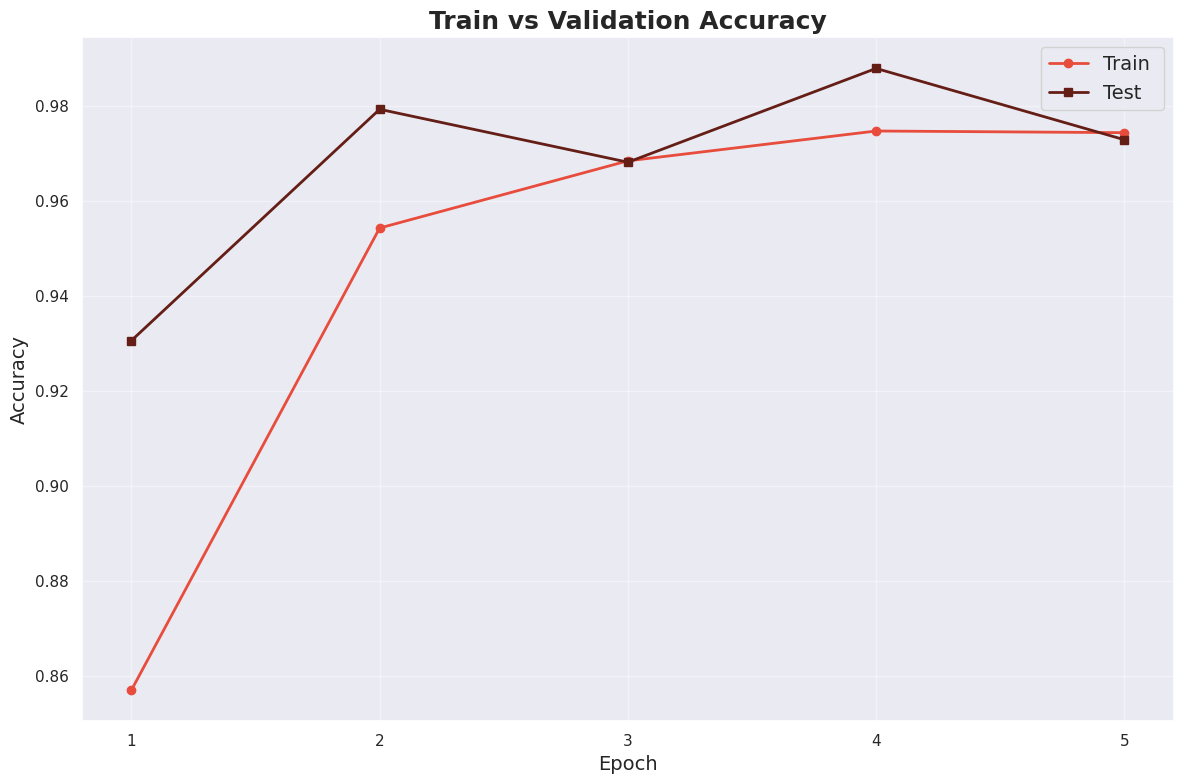

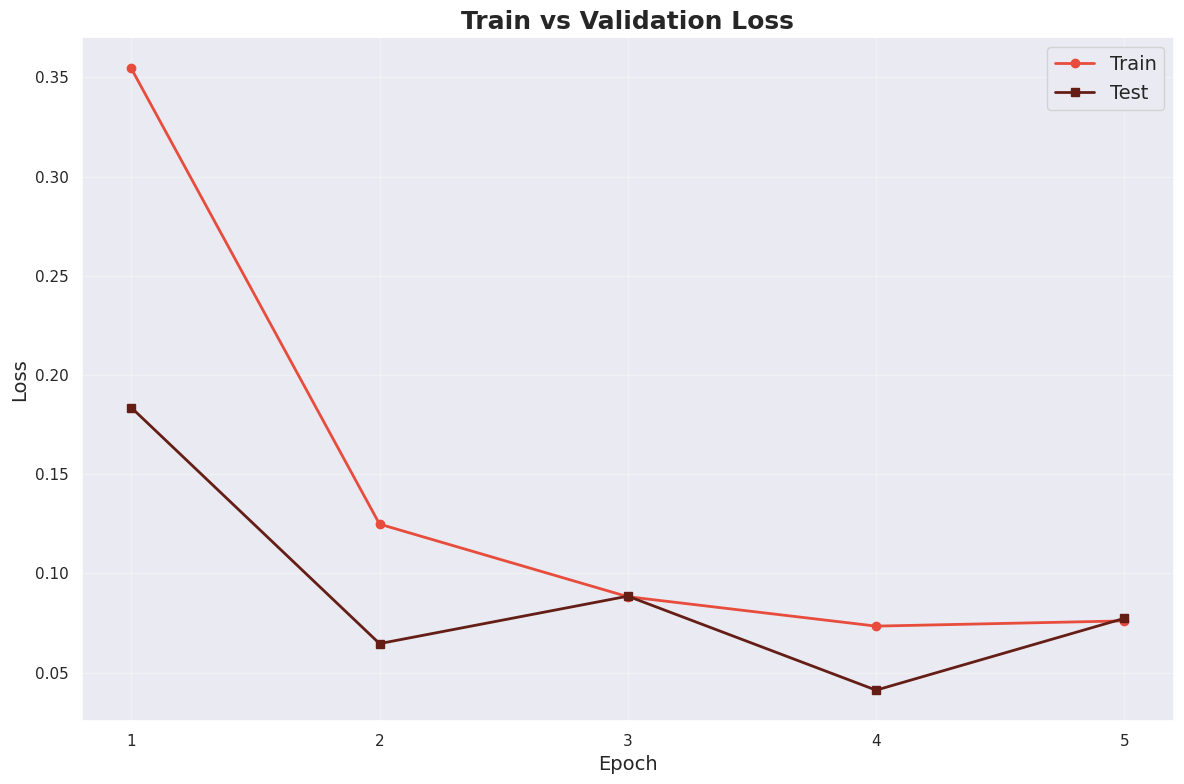

In [18]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)


plt.figure(figsize=(12, 8))
plt.plot(epochs, train_acc, label='Train ', color="#E74C3C", marker='o', linewidth=2)
plt.plot(epochs, val_acc, label='Test', color='#641E16', marker='s', linewidth=2)

plt.title('Train vs Validation Accuracy', fontsize=18, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(epochs)  
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)


plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss, label='Train', color="#E74C3C", marker='o', linewidth=2)
plt.plot(epochs, val_loss, label='Test', color='#641E16', marker='s', linewidth=2)

plt.title('Train vs Validation Loss', fontsize=18, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(epochs)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

Burada daha önce eğitim sırasında en iyi doğruluk gösteren modeli yükledim. load_model('my_best_Model_v2.keras') ile kaydettiğim modeli tekrar çağırıp, yeni veriler üzerinde tahmin yapabilir veya performansını değerlendirebilirim. Böylece modeli yeniden eğitmek zorunda kalmadan, en iyi öğrendiği haliyle kullanabiliriz. Bu hem zamandan tasarruf sağlar hem de overfitting veya yanlış eğitimin önüne geçer.

In [20]:
from keras.models import load_model
cnn=load_model('my_Best_Model_v2.keras')

Sonraki aşama, yüklediğim en iyi modelle test verisi üzerinde tahminler yaptırıp ve performansını değerlendirdim. İlk olarak cnn.build((None, 100, 100, 3)) ile modelin input boyutunu belirttim ; bu sayede model, batch boyutu ne olursa olsun 100x100 boyutlu ve 3 kanallı görselleri kabul ediyor.

Ardından cnn.predict(test_generator) ile test verilerini kullanarak tahmin olasılıklarını aldım ve np.argmax ile her örnek için en yüksek olasılığa sahip sınıfı belirledim. Gerçek etiketleri de test_generator.classes ile aldım.

Sonra confusion_matrix ile modelin hangi sınıfları doğru veya yanlış tahmin ettiğini gösteren confusion matrix'i oluşturdum. sns.heatmap ile bunu görselleştirip x ekseninde tahmin edilen sınıfları, y ekseninde gerçek sınıfları göstermesini sağladım.

Ayrıca classification_report ile modelin precision, recall, f1-score ve accuracy değerlerini yazdırdım. Bu sayede sadece genel doğruluğu değil, her pirinç türü için modelin ne kadar başarılı olduğunu detaylı bir şekilde görebiliriz.

Özetle, modelin gerçek performansını test verisi üzerinde değerlendirip ve hangi sınıflarda daha iyi veya kötü olduğunu görselleştirdim.

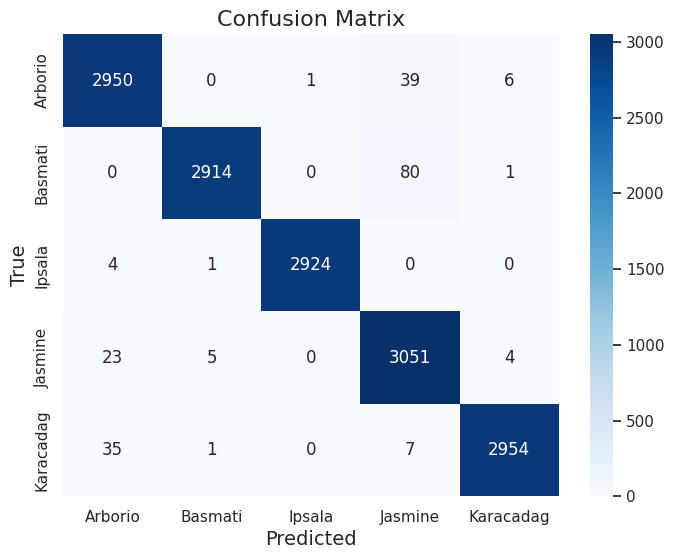


=== Classification Report ===

              precision    recall  f1-score   support

     Arborio       0.98      0.98      0.98      2996
     Basmati       1.00      0.97      0.99      2995
      Ipsala       1.00      1.00      1.00      2929
     Jasmine       0.96      0.99      0.97      3083
   Karacadag       1.00      0.99      0.99      2997

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



In [22]:
cnn.build((None, 100, 100, 3)) 


from sklearn.metrics import confusion_matrix, classification_report


y_pred_prob = cnn.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

print("\n=== Classification Report ===\n")
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

Bu projede, beş farklı pirinç türünü ayırt edebilen bir CNN modeli geliştirdim. Önce veri setini yükleyip resimleri ve etiketleri düzenledim, sonra eğitim ve test verilerini ayırdım. Eğitim sırasında Data Augmentation yöntemleri kullanarak modelin farklı durumlara uyum sağlamasını sağladım ve overfitting’i azaltmaya çalıştım. Modeli oluşturup eğittikten sonra doğruluk ve kayıp grafiklerini inceleyerek öğrenme sürecini gözlemledim. En iyi performans gösteren modeli kaydedip test verisi üzerinde tahminler yaparak, confusion matrix ve classification report ile modelin hangi pirinç türlerinde iyi veya kötü tahmin yaptığını gördüm.

Bu proje sayesinde CNN’leri nasıl kuracağımı, veriyi nasıl hazırlayacağımı ve modelin performansını nasıl değerlendireceğimi pratik olarak öğrendim. Ayrıca, derin öğrenme projelerinde adım adım ilerlemenin ve görselleştirmenin önemini de fark ettim.